In [9]:
import cv2
import csv

# For GPU server
#path = '/lfs/mead9103.ui/NN_Training/'
#path = ''

def video_to_CSV(filename, frames = 240):
    # Open the video file
    cap = cv2.VideoCapture(filename)

    if not cap.isOpened():
        print("Cannot open camera for video %s" % filename)
        return

    # Define the keypoint mapping for this OpenPose body_25 model
    keypoints_mapping = {
        0:  "Nose", 1:  "Neck", 2:  "RShoulder", 3:  "RElbow", 4:  "RWrist", 5:  "LShoulder", 6:  "LElbow",
        7:  "LWrist", 8:  "MidHip", 9:  "RHip", 10: "RKnee", 11: "RAnkle", 12: "LHip", 13: "LKnee",
        14: "LAnkle", 15: "REye", 16: "LEye", 17: "REar", 18: "LEar", 19: "LBigToe", 20: "LSmallToe",
        21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel"
    }
    #load the model
    net = cv2.dnn.readNetFromCaffe('pose_deploy.prototxt', 'pose_iter_584000.caffemodel')

    #Write frame information of joint locations into a csv file
    f = open(filename + ".csv", 'w', newline='')
    w = csv.writer(f)
    #for keypoint, label in keypoints_mapping:
        #w.write(str(keypoints_mapping.items())
    #w.writerow(keypoints_mapping.values())
    
    def framestep(cap):
        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        new_vid = []
        # Keep stepsize as a float, consider someday skipping frame 0 since it's unlikely to be useful
        stepsize = (frame_count - 1) / (frames - 1) # subtract 1 to account for frame 0
        print("Video: %s, frames to be analyzed: %d (%d / %.2f)" % (filename, frames, frame_count, stepsize))
        curr_frame = 0
        i = 0 # float index of next frame
        
        # Loop until the whole video has been read, or the requested number of frames are reached
        while curr_frame < frame_count:
            ret, frame = cap.read()
            if curr_frame == int(i):
                print("Starting frame: %d (index %.2f)" % (curr_frame, i))
                new_vid.append(pose(frame))
                i += stepsize
            curr_frame += 1
        return new_vid
        
    def squarify(frame):
        height, width, _ = frame.shape
        min_dim = min(height, width)

        # Calculate the cropping dimensions
        crop_height = (height - min_dim) // 2
        crop_width = (width - min_dim) // 2

        # Crop the image equally from both sides to make it a square
        return frame[crop_height:crop_height+min_dim, crop_width:crop_width+min_dim] , min_dim

    def pose(frame):
        frame, size = squarify(frame)
        blob = cv2.dnn.blobFromImage(frame, 1/255, (size, size),
                                (0, 0, 0), swapRB=False, crop=True)

        # run forward pass to get the pose estimation
        net.setInput(blob)
        output = net.forward()
        
        # Extract joint locations
        joint_locations = []
        csv_joint_locations = []

        for i in range(len(keypoints_mapping)): #-1 bc we dont want point for the background
            keypoint = output[0, i, :, :]
            min_val, confidence, min_loc, point = cv2.minMaxLoc(keypoint)

            #if confidence > 0.1:  # can adjust the confidence threshold if needed ???
            joint_locations.append((8 * int(point[0]), 8 * int(point[1]), 0)) #for testing/human readable
            csv_joint_locations.append(8 * int(point[0])) #to be printed into csv
            csv_joint_locations.append(8 * int(point[1])) #to be printed into csv
            csv_joint_locations.append(0) #to be printed into csv
            '''else:
                joint_locations.append(None) #for testing/human readable
                csv_joint_locations.append(8 * int(point[0])) #to be printed into csv
                csv_joint_locations.append(8 * int(point[1])) #to be printed into csv
            '''
        #joint_locations contains the locations of the detected joints and corresponding index

        '''for location in joint_locations:
            if location:
                x, y, index = location
                cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
                #cv2.putText(image, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        '''        
        #print joint locations into a csv file
        w.writerow(csv_joint_locations)
        
        return frame

    #write the information + circles onto each frame and pop up a window for each frame
    my_video = framestep(cap)
    size = my_video[0].shape[1], my_video[0].shape[0]
    print(size)
    '''out = cv2.VideoWriter("real.avi", cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(my_video)):
        out.write(my_video[i])
        cv2.imshow("video", my_video[i])
        cv2.waitKey(0)

    cv2.destroyAllWindows()
    out.release()
    '''
    cap.release()
    f.close()

In [10]:
import pandas as pd
import numpy as np
import sys

def replace_outliers(data, window_size=5, threshold=2.0):
    """
    Replace outliers in each column with the average of adjacent points within a specified window.

    Parameters:
    - data: pandas DataFrame
    - window_size: int, the size of the window for calculating the average (default is 5)
    - threshold: float, the threshold for identifying outliers (default is 2.0)

    Returns:
    - data: pandas DataFrame, with outliers replaced
    """
    for column_name in data.columns:
        x = data[column_name].values

        # Identify outliers based on the average of points within the window
        for i in range(window_size, len(x) - window_size):
            window_avg = x[i - window_size:i + window_size + 1].mean()
            if np.abs(x[i] - window_avg) > threshold * x.std():
                x[i] = window_avg

        # update the dataframe
        data[column_name] = x
    return data

def moving_average(data):
    smoothed_data = pd.DataFrame()

    for i in range(0, len(data.columns)):
        x_col = data.columns[i]

        x = data[x_col].values

        # Apply the new weights for the moving average
        x_smoothed = 0.1 * pd.Series(x).shift(-1, fill_value=x[-1]).values + 0.8 * x + 0.1 * pd.Series(x).shift(1, fill_value=x[0]).values
        smoothed_data[x_col] = x_smoothed

    return smoothed_data

def smooth_and_save(input_file):
    # Load your CSV data into a pandas DataFrame
    df = pd.read_csv(input_file, header=None)

    replace_outliers(df)
    # adjust each point with a moving average of the previous 2 points
    smoothed_data = moving_average(df)

    # Save the smoothed data to a new CSV file
    output_file = input_file.replace('.csv', '_smoothed.csv')
    smoothed_data.to_csv(output_file, index=False, header = False)
    print(f'Smoothed data saved to {output_file}')


In [11]:

#video_to_CSV("Molly_Correct_DeepSquat.mp4", frames_to_analyze) #get the data for correct squat
#video_to_CSV("Molly_Incorrect_DeepSquat.mp4", frames_to_analyze) #get the data for incorrect squat

#smooth_and_save("Molly_Correct_DeepSquat.mp4.csv")
#smooth_and_save("Molly_Incorrect_DeepSquat.mp4.csv")


In [12]:
#reshape data

def reshapeUserData(filename):
    df1 = pd.read_csv(filename + "_smoothed.csv", header=None)
    raw_data = df1.to_numpy()
    #print(raw_data)
    raw_data_1 = raw_data.reshape(75 * frames_to_analyze)
    raw_data_2 = raw_data_1.reshape(75, frames_to_analyze, order = 'F')
    data_mean = np.mean(raw_data_2, axis = 0)
    centered_data = raw_data_2 - data_mean
    scaling_value = np.ceil(max(np.max(centered_data), abs(np.min(centered_data))))
    data_correct = centered_data / scaling_value
    #print(raw_data_2)
    
    #open and write reshaped data to a csv
    f = open(filename + "_smoothed.csv", 'w', newline = '')
    w = csv.writer(f)
    np.apply_along_axis(w.writerow, axis = 1, arr = data_correct)
    f.close()

#incorrect reshape
#Inc = pd.read_csv("Molly_Incorrect_DeepSquat.mp4_smoothed.csv", header=None)
#Inc_raw_data = Inc.to_numpy()
#Inc_raw_data_1 = Inc_raw_data.reshape(75 * frames_to_analyze)
#Inc_raw_data_2 = Inc_raw_data_1.reshape(75, frames_to_analyze, order = 'F')

In [13]:
'''
Inc_data_mean = np.mean(Inc_raw_data_2, axis = 0)


centered_data_inc = Inc_raw_data_2 - Inc_data_mean

# Scale the data between -1 and 1


# Scale the incorrect data between -1 and 1
scaling_value_inc = np.ceil(max(np.max(centered_data_inc), abs(np.min(centered_data_inc))))
data_incorrect = centered_data_inc / scaling_value_inc
'''

'\nInc_data_mean = np.mean(Inc_raw_data_2, axis = 0)\n\n\ncentered_data_inc = Inc_raw_data_2 - Inc_data_mean\n\n# Scale the data between -1 and 1\n\n\n# Scale the incorrect data between -1 and 1\nscaling_value_inc = np.ceil(max(np.max(centered_data_inc), abs(np.min(centered_data_inc))))\ndata_incorrect = centered_data_inc / scaling_value_inc\n'

In [14]:
'''
f = open(path + 'Molly_data_incorrect.csv', 'w', newline = '')
w = csv.writer(f)
np.apply_along_axis(w.writerow, axis = 1, arr = data_incorrect)

f.close()
'''

"\nf = open(path + 'Molly_data_incorrect.csv', 'w', newline = '')\nw = csv.writer(f)\nnp.apply_along_axis(w.writerow, axis = 1, arr = data_incorrect)\n\nf.close()\n"

In [15]:
episodes = 1
features = 75
frames_to_analyze = 40
path = "C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/"

def analyzeUserVideo(filename):
    video_to_CSV(path + filename, frames_to_analyze) #get the data for correct squat
    smooth_and_save(path + filename + ".csv")
    reshapeUserData(path + filename)

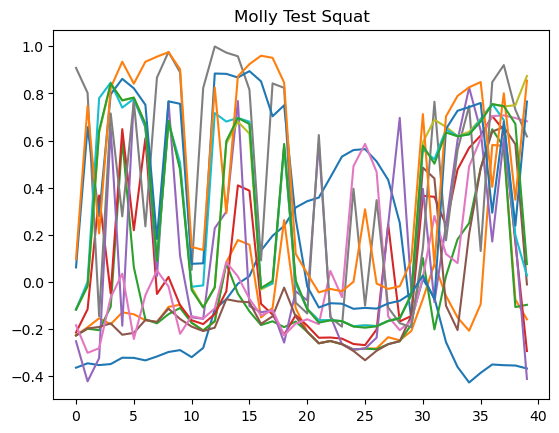

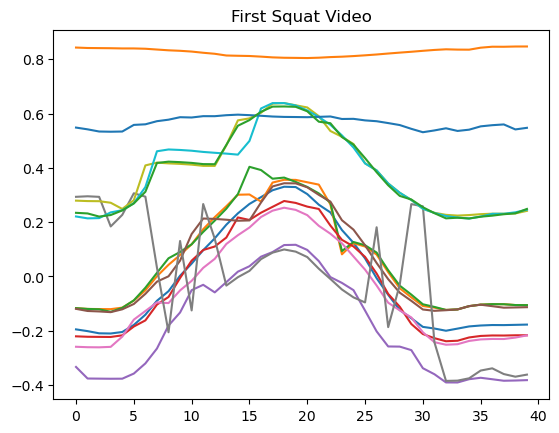

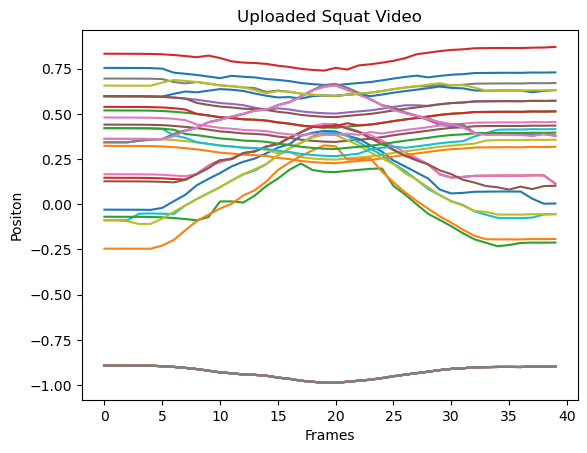

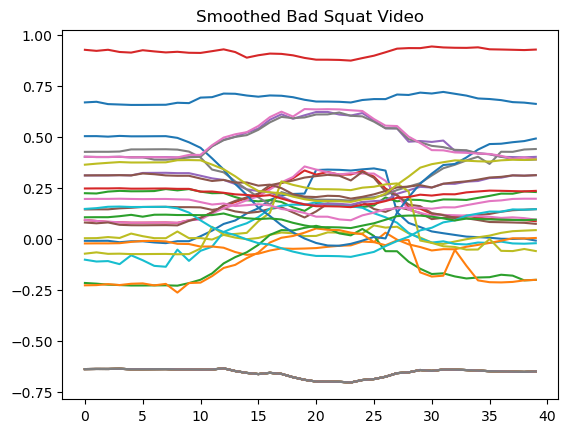

In [18]:
#analyzeUserVideo("VID_20240305_154742900.mp4")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(path + "VID_20240305_154742900.mp4_smoothed.csv", header=None)
arr1 = df.to_numpy()
arr2 = np.swapaxes(arr1, 0, 1) # put frames on x axis
#print(arr1)
#print(arr2)
molly = arr2[:, range(1, len(arr2), 3)] # select y points

one_move = pd.read_csv("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/" + "smoothed_data_correct.csv", header = None)
one_move1 = one_move[0:75].to_numpy()
one_move2 = np.swapaxes(one_move1, 0, 1)
video = one_move2[:, range(1, len(one_move2), 3)]

plt.plot(molly)
plt.title('Molly Test Squat')
plt.show()

plt.plot(video)
plt.title('First Squat Video')
plt.show()

n = pd.read_csv("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_152924506_smoothed.csv", header = None)
new = n.to_numpy()
new2 = np.swapaxes(new, 0, 1)
news = new2[:, range(1, len(new2))]

plt.plot(news)
plt.title('Uploaded Squat Video')
plt.xlabel('Frames')
plt.ylabel('Positon')
plt.show()

b = pd.read_csv("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_153058147_smoothed.csv", header = None)
bad = b.to_numpy()
bad2 = np.swapaxes(bad, 0, 1)
bads = bad2[:, range(1, len(bad2))]

plt.plot(bads)
plt.title('Smoothed Bad Squat Video')
plt.show()
#analyzeUserVideo("VID_20240305_154756887.mp4")
#analyzeUserVideo("VID_20240305_154829145.mp4")
#analyzeUserVideo("VID_20240305_154844653.mp4")
#analyzeUserVideo("VID_20240305_154954638.mp4")
#analyzeUserVideo("VID_20240305_155018185.mp4")

In [ ]:
def showExer(filename):
    b = pd.read_csv(filename, header = None)
    bad = b.to_numpy()
    bad2 = np.swapaxes(bad, 0, 1)
    bads = bad2[:, range(1, len(bad2), 3)] # range(1, len(bad2), 3)

    plt.plot(bads)
    plt.title(filename)
    plt.show()

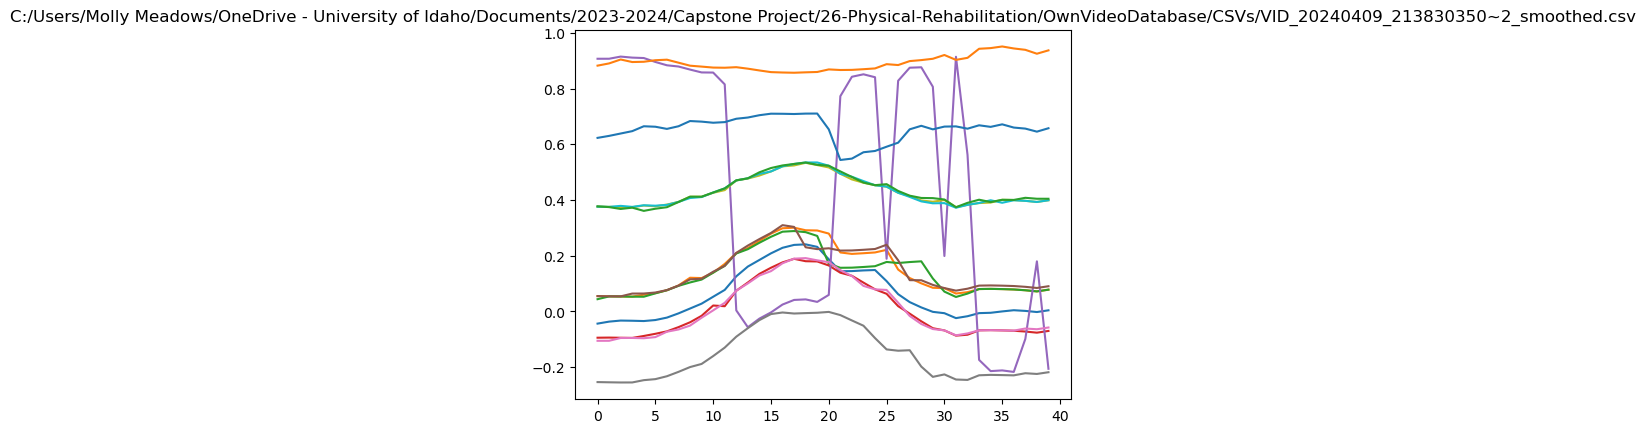

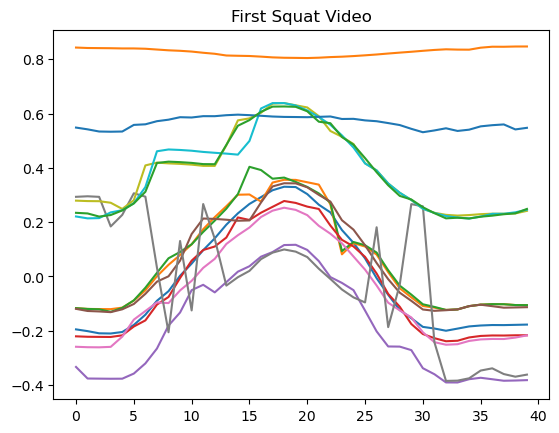

In [67]:
showExer("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/OwnVideoDatabase/CSVs/VID_20240409_213830350~2_smoothed.csv")
#showExer("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/OwnVideoDatabase/CSVs/VID_20240409_213830350~3_smoothed.csv")
#showExer("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/OwnVideoDatabase/CSVs/VID_20240409_213830350~4_smoothed.csv")


#video from UI_PRMD database
one_move = pd.read_csv("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/" + "smoothed_data_correct.csv", header = None)
one_move1 = one_move[0:75].to_numpy()
one_move2 = np.swapaxes(one_move1, 0, 1)
video = one_move2[:, range(1, len(one_move2), 3)]

plt.plot(video)
plt.title('First Squat Video')
plt.show()